env `nlp_mlops`

## Directory

In [1]:
import os
os.chdir("../")
os.getcwd()

'c:\\Users\\Marina\\Desktop\\ML Operations\\0 - KrishNaik Course\\21_end_to_end_nlp_project_with_huggingface_and_transformers\\my_project'

## 1. Config.yaml

Vamos fazer isso, criando a classe `model_evaluation` 

## 2. Params.yaml

Criado para nos auxiliar no treinamento

## 3. Config entity

In [2]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen= True)
class ModelEvaluationConfig():
  root_dir: Path
  data_path: Path # vem de cima
  model_path: Path # artefato do anterior
  tokenizer_path: Path # artefato do anterior
  metric_file_name: str # output  


## 4. Configuration Manager

Vamos criar umas constanstes 

In [3]:
from src.textSummarizer.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from src.textSummarizer.utils.common import read_yaml, create_directories
from typing import Tuple

class ConfigurationManager:
    def __init__(self,
                config_path= CONFIG_FILE_PATH,
                params_path= PARAMS_FILE_PATH ):
        
        self.configurations = read_yaml(config_path)
        self.params = read_yaml(params_path)

        create_directories([self.configurations.artifacts_root]) # cria o /artifacts


    def get_model_evaluation_config(self)-> ModelEvaluationConfig:
        
        model_evaluation_config = self.configurations.model_evaluation
        
        create_directories([model_evaluation_config.root_dir]) # cria o /artifacts/model_trainer

        return model_evaluation_config


In [4]:
config = ConfigurationManager()
model_evaluation_config = config.get_model_evaluation_config()
print(model_evaluation_config)


[ 2024-11-13 15:10:11,446 ] - 28 summarizerlogger - INFO - yaml file: config\config.yaml loaded successfully
[ 2024-11-13 15:10:11,478 ] - 28 summarizerlogger - INFO - yaml file: params.yaml loaded successfully
[ 2024-11-13 15:10:11,481 ] - 46 summarizerlogger - INFO - created directory at: artifacts


[ 2024-11-13 15:10:11,484 ] - 46 summarizerlogger - INFO - created directory at: artifacts/model_evaluation
{'root_dir': 'artifacts/model_evaluation', 'data_path': 'artifacts/data_transformation/samsum_dataset', 'model_path': 'artifacts/model_trainer/pegasus-samsum-model', 'tokenizer_path': 'artifacts/model_trainer/tokenizer', 'metric_file_name': 'artifacts/model_evaluation/metrics.csv'}


## 5. Update the components- Data Ingestion,Data Transformation, Model Trainer

In [10]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from datasets import load_from_disk
import evaluate
import pandas as pd
from tqdm import tqdm


In [19]:
from src.textSummarizer.logging import logger

class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def generate_batch_sized_chunks(self,list_of_elements, batch_size):
        """split the dataset into smaller batches that we can process simultaneously
        Yield successive batch-sized chunks from list_of_elements."""
        for i in range(0, len(list_of_elements), batch_size):
            yield list_of_elements[i : i + batch_size]

    def calculate_metric_on_test_ds(self,dataset, metric, model, tokenizer, 
                               batch_size=16, device="cuda" if torch.cuda.is_available() else "cpu", 
                               column_text="article", 
                               column_summary="highlights"):
        article_batches = list(self.generate_batch_sized_chunks(dataset[column_text], batch_size))
        target_batches = list(self.generate_batch_sized_chunks(dataset[column_summary], batch_size))

        for article_batch, target_batch in tqdm(
            zip(article_batches, target_batches), total=len(article_batches)):
            
            inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                            padding="max_length", return_tensors="pt")
            
            summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                            attention_mask=inputs["attention_mask"].to(device), 
                            length_penalty=0.8, num_beams=8, max_length=128)
            ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
            
            # Finally, we decode the generated texts, 
            # replace the  token, and add the decoded texts with the references to the metric.
            decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                    clean_up_tokenization_spaces=True) 
                for s in summaries]      
            
            decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
            
            
            metric.add_batch(predictions=decoded_summaries, references=target_batch)
            
        #  Finally compute and return the ROUGE scores.
        score = metric.compute()
        return score
    
    def evaluate(self):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        # tokenizer = AutoTokenizer.from_pretrained(self.config.tokenizer_path)
        tokenizer = AutoTokenizer.from_pretrained("artifacts/model_trainer/tokenizer", use_fast=False)
        model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(self.config.model_path).to(device)
        # model_pegasus = AutoModelForSeq2SeqLM.from_pretrained("artifacts/model_trainer/pegasus-samsum-model").to(device)

       
        #loading data 
        dataset_samsum_pt = load_from_disk(self.config.data_path)


        rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

        rouge_metric = evaluate.load('rouge')

        #rouge_metric = rouge_metric

        score = self.calculate_metric_on_test_ds(
        dataset_samsum_pt['test'][0:10], rouge_metric, model_pegasus, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
            )

        # Directly use the scores without accessing fmeasure or mid
        rouge_dict = {rn: score[rn] for rn in rouge_names}

        df = pd.DataFrame(rouge_dict, index = ['pegasus'] )
        df.to_csv(self.config.metric_file_name, index=False)

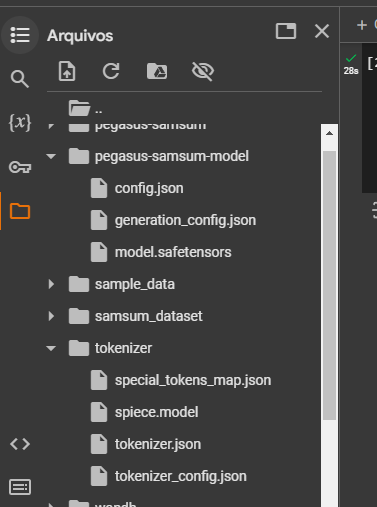

In [20]:
config = ConfigurationManager()
model_evaluation_config = config.get_model_evaluation_config()
model_evaluation_config = ModelEvaluation(config=model_evaluation_config)
model_evaluation_config.evaluate()


[ 2024-11-13 16:43:00,263 ] - 28 summarizerlogger - INFO - yaml file: config\config.yaml loaded successfully
[ 2024-11-13 16:43:00,270 ] - 28 summarizerlogger - INFO - yaml file: params.yaml loaded successfully
[ 2024-11-13 16:43:00,272 ] - 46 summarizerlogger - INFO - created directory at: artifacts
[ 2024-11-13 16:43:00,274 ] - 46 summarizerlogger - INFO - created directory at: artifacts/model_evaluation


C:\Users\Marina\AppData\Roaming\Python\Python311\site-packages\transformers\generation\configuration_utils.py:444: UserWarning: `num_beams` is set to None - defaulting to 1.
  warnings.warn("`num_beams` is set to None - defaulting to 1.", UserWarning)


AttributeError: module 'evaluate' has no attribute 'utils'

Emulei o treinamento usando o google colab e baixnado o modelo e o tokenizer

## 6. Modularizar o Código

O `3.` vai para `src\textSummarizer\entity\__init__.py`

O `4.` vai para `src\textSummarizer\config\configuration.py`

O `5.` vai para `src\textSummarizer\components\data_transformation.py`

Modularizamos criando uma pipeline (classe) em `stage_3_model_trainer_pipeline.py`, com o que usamos para rodar o código

Jogar a Pipeline para `main.py`